# Problem

This dataset is a record of 7 common different fish species in fish market sales. We want a model to estimate a fish's weight. 

https://www.kaggle.com/aungpyaeap/fish-market

# Summary of Results

Several linear regression models were used. The RANSACRegressor produced the best r2 score of `0.939`.

***

In [1]:
!pip install kaggle

In [2]:
import kaggle

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="darkgrid")
%matplotlib inline

# Exploratory Data Analysis

In [3]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('aungpyaeap/fish-market', path='data/', unzip=True)

## Data Dictionary

* Species: Species name of fish
* Weight: Weight of fish in gram
* Length1: Vertical length in cm
* Length2: Diagonal length in cm
* Length3: Cross length in cm
* Height: Height in cm
* Width: Diagonal width in cm

In [4]:
data = pd.read_csv('./data/Fish.csv')

## Overview

First, we gather basic impressions and answer basic questions abou the data like,

* What do some sample values look like?
* How many rows are there and what are their types?

In [5]:
data.sample(frac=.1).head(10)

,Species,Weight,Length1,Length2,Length3,Height,Width
65,Parkki,150.0,18.4,20.0,22.4,8.8928,3.2928
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
25,Bream,725.0,31.8,35.0,40.9,16.3600,6.0532
147,Smelt,7.0,10.1,10.6,11.6,1.7284,1.1484
95,Perch,170.0,21.5,23.5,25.0,6.2750,3.7250
118,Perch,820.0,36.6,39.0,41.3,12.4313,7.3514
29,Bream,1000.0,33.5,37.0,42.6,18.9570,6.6030
16,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854
86,Perch,120.0,20.0,22.0,23.5,6.1100,3.4075
58,Whitefish,540.0,28.5,31.0,34.0,10.7440,6.5620


In [6]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


## Data Quality

* Is there missing data?
* Are columns the right types?
* Are there outliers in any of the columns? Consider uni-variate and multi-variate analysis. 

#### *Is there missing data?*

In [8]:
print(str('Are there any missing values in the dataset?'), data.isnull().values.any())

Are there any missing values in the dataset? False


#### *Are columns the right types?*

In [9]:
pd.DataFrame(data['Species'].value_counts()).T

,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
Species,56,35,20,17,14,11,6


We can see from the data type displayed in the overview section and the data above that the `Species` columns is categorical.

In [10]:
 data['Species'] = data['Species'].astype('category')

#### *Are there outliers in any of the columns?*

**Univariate Analysis** 

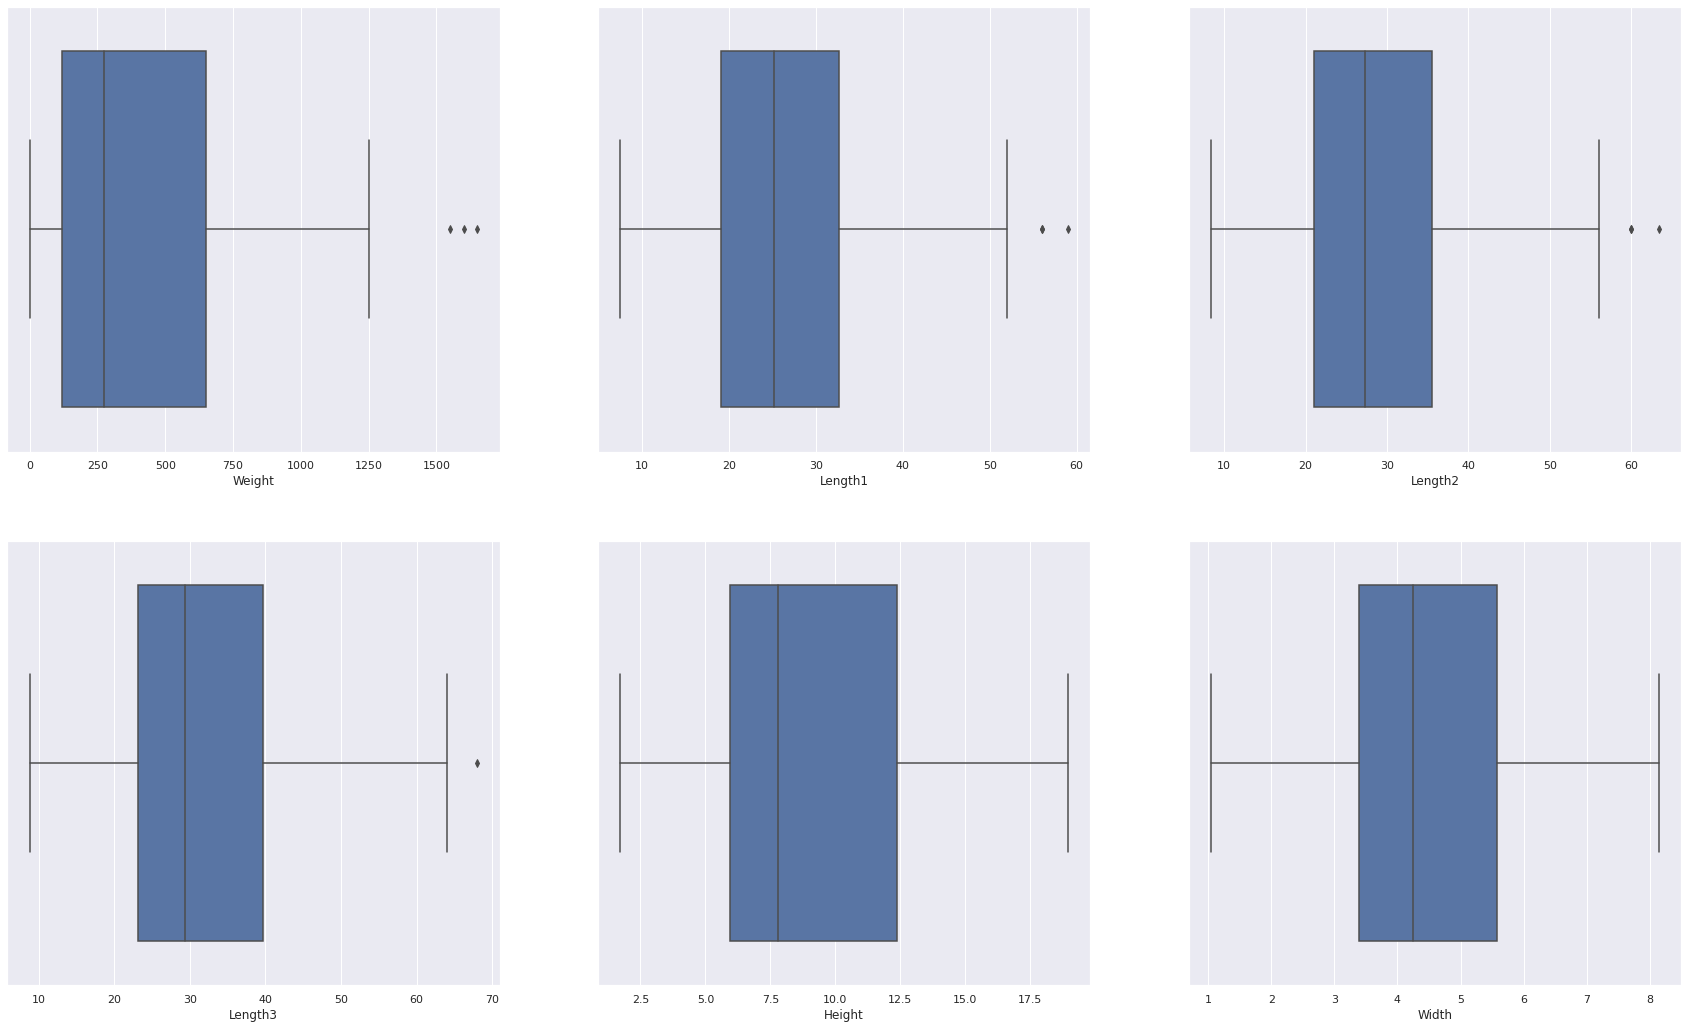

In [11]:
boxplot_fields = ['Weight','Length1','Length2','Length3','Height','Width']
fig, ax = plt.subplots(2, 3, figsize=(30, 18))
for var, subplot in zip(boxplot_fields, ax.flatten()):
    sns.boxplot(x=var, data=data, ax=subplot)

**Multi-Variate Analysis**

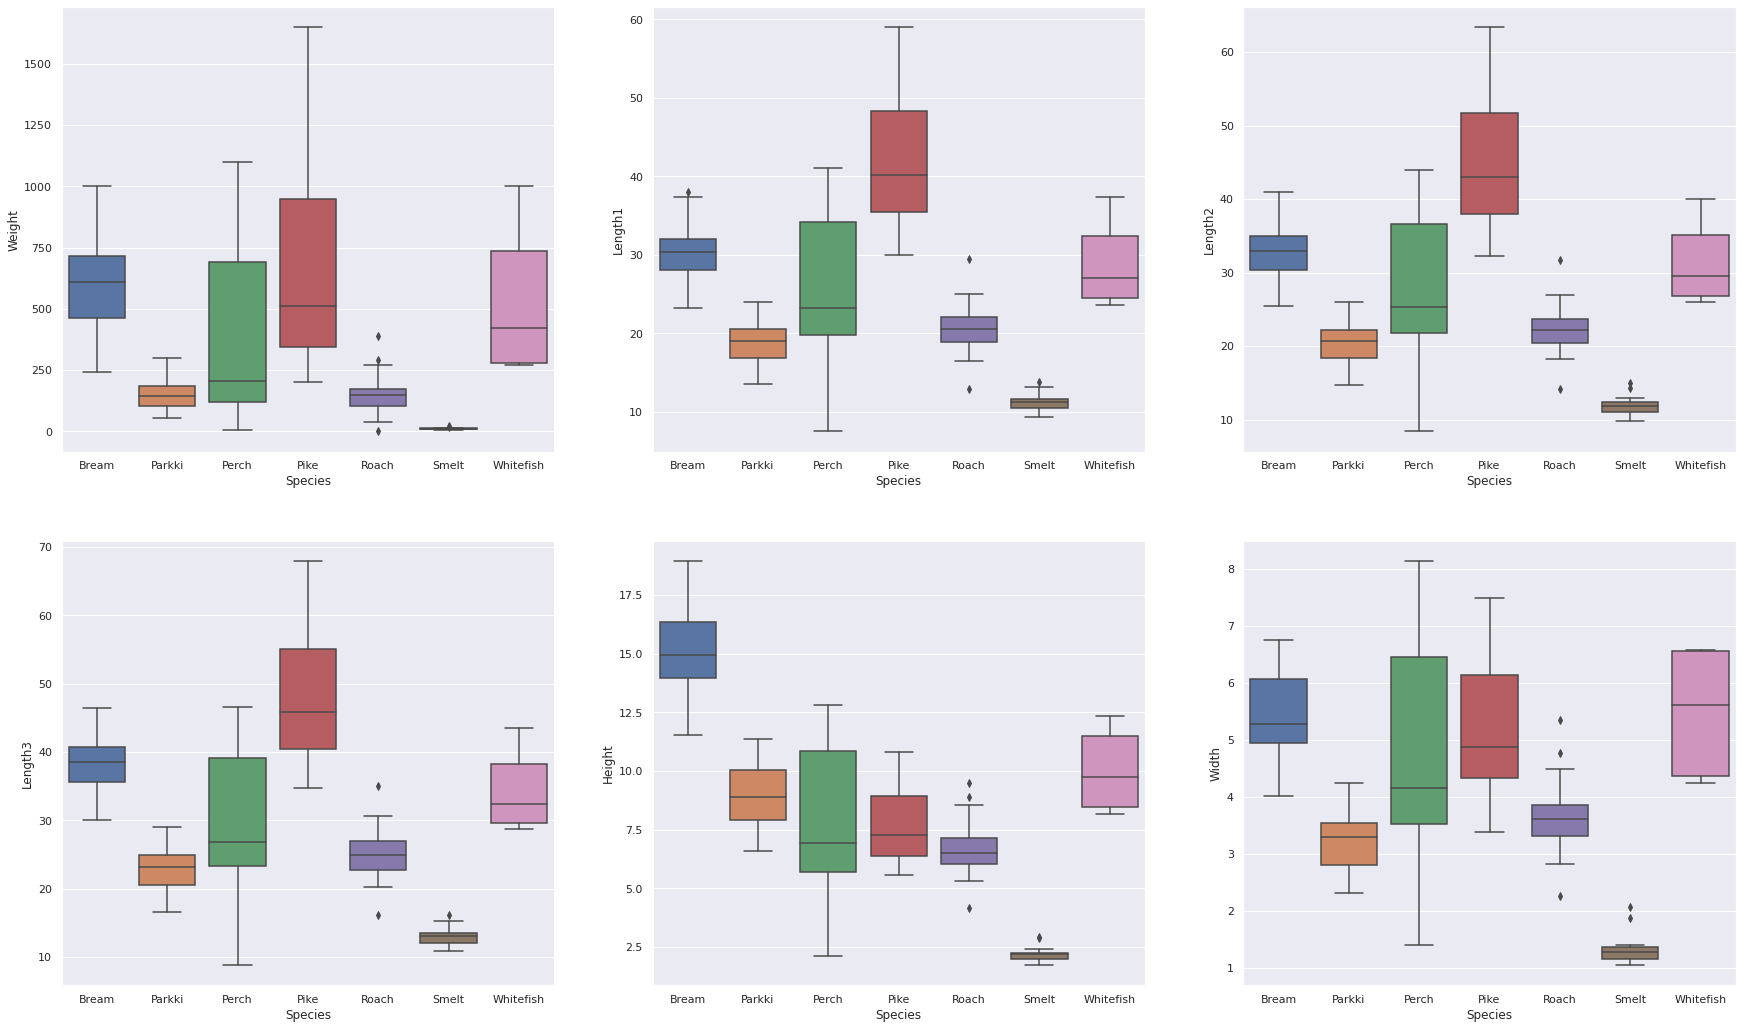

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(30, 18))
for var, subplot in zip(boxplot_fields, ax.flatten()):
    sns.boxplot(x='Species', y=var, data=data, ax=subplot)

In [96]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lowerend = 0 # This would otherwise be Q1[c] - (1.5 * IQR[c]) but negative values don't make sense for the variables.
upperend = Q3 + (1.5 * IQR)

for c in boxplot_fields:
    print(c + ':')
    upperend = Q3[c] + (1.5 * IQR[c])
    feature = data[c]
    outliers = feature[(feature <= lowerend) | (feature > upperend)]
    print(outliers)

Weight:
40        0.0
142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64
Length1:
142    56.0
143    56.0
144    59.0
Name: Length1, dtype: float64
Length2:
142    60.0
143    60.0
144    63.4
Name: Length2, dtype: float64
Length3:
144    68.0
Name: Length3, dtype: float64
Height:
Series([], Name: Height, dtype: float64)
Width:
Series([], Name: Width, dtype: float64)


In [97]:
fishes = data[~((data[boxplot_fields] <= 0) | (data[boxplot_fields] > (Q3 + 1.5 * IQR))).any(axis=1)]

## Graphical Exploration

#### Distributional Observations

An early step in any effort to analyze or model data is understanding how the variables are distributed.

* What range do the observations cover? 
* What is their central tendency? 
* Are they heavily skewed in one direction? 
* Is there evidence for bimodality? 
* Are there significant outliers? 
* Do the answers to these questions vary across subsets defined by other variables?
* Is the response variable imbalanced?

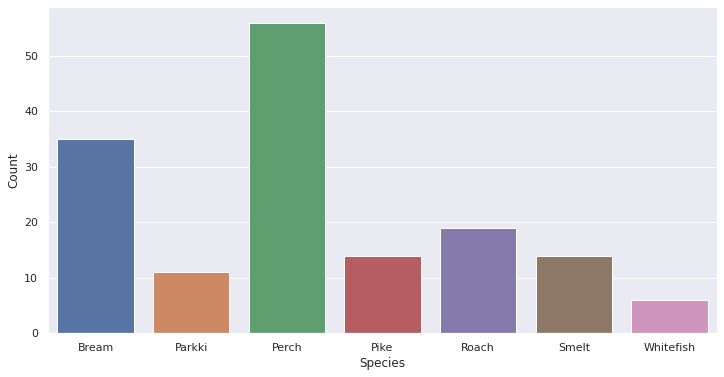

In [98]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Species", data=fishes);
ax.set_ylabel("Count")
plt.show()

*Observations*
* If the response variable were `Species` then this plot would tell use that we have an imbalanced dataset.

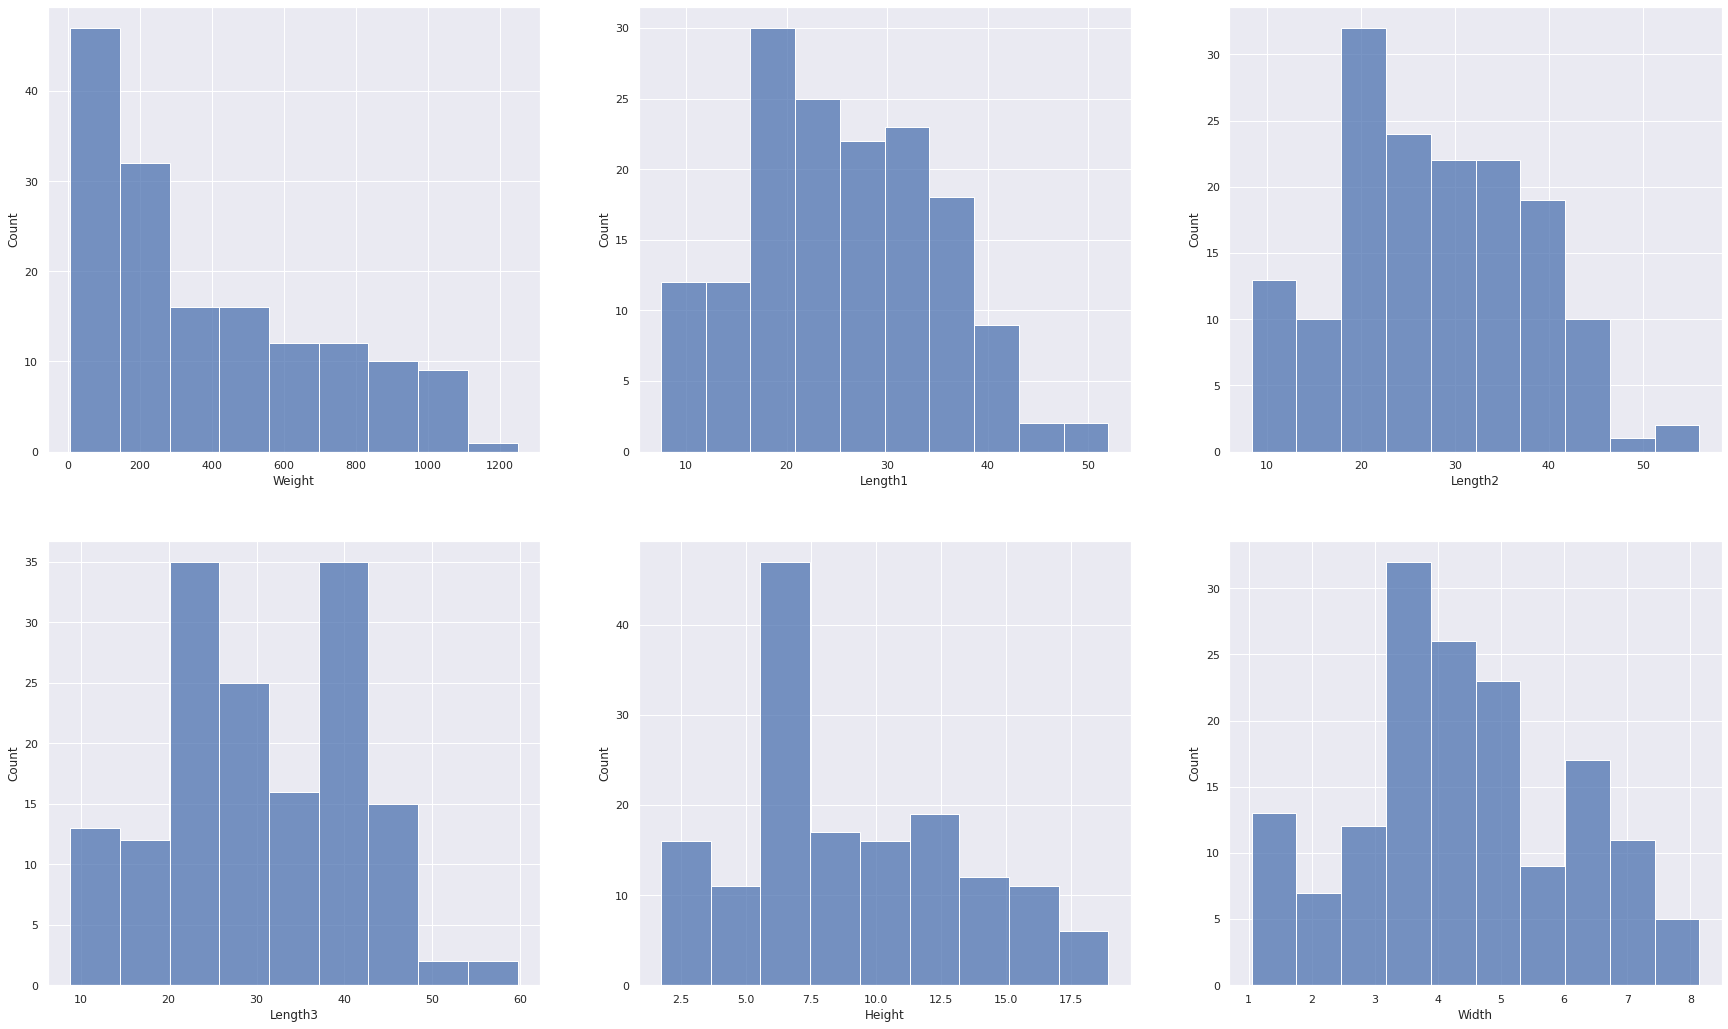

In [99]:
columns_for_hist = ['Weight','Length1','Length2','Length3','Height','Width']
fig, ax = plt.subplots(2, 3, squeeze=True, figsize=(30, 18))
for col, subplot in zip(columns_for_hist, ax.flatten()):
    sns.histplot(fishes, x=col, ax=subplot);

*Observations*
* Length[1,2,3] have nearly identical distributions 
* Width approximates an normal distribution. A normality test would provide more exact information.

#### Relationships

First I'll explore correlations. In statistical terms, correlation is a method of assessing a possible two-way linear association between two continuous variables. 

In [250]:
fishes_trans = fishes.copy()

fishes_trans['Width'] = np.log(fishes_trans['Width'])
fishes_trans['Height'] = np.log(fishes_trans['Height'])
fishes_trans['Length1'] = np.log(fishes_trans['Length1'])
fishes_trans = pd.get_dummies(data=fishes_trans, drop_first=True)

**Pearson's Correlation**

The Pearson product-moment correlation attempts to draw a line of best fit through the data of two variables. The Pearson correlation coefficient, *r*, indicates how far away all these data points are to this line of best fit (i.e., how well the data points fit this new model/line of best fit). The key assumptions of using this statistic are,

* Both variables being studied are normally distributed
* This coefficient is affected by extreme values, which may exaggerate or dampen the strength of relationship, and is therefore inappropriate when either or both variables are not normally distributed.

The condition of normal distribution isn't well satisfied from what we can see in the histograms above, but I examine the values for the purposes of understanding our problem.

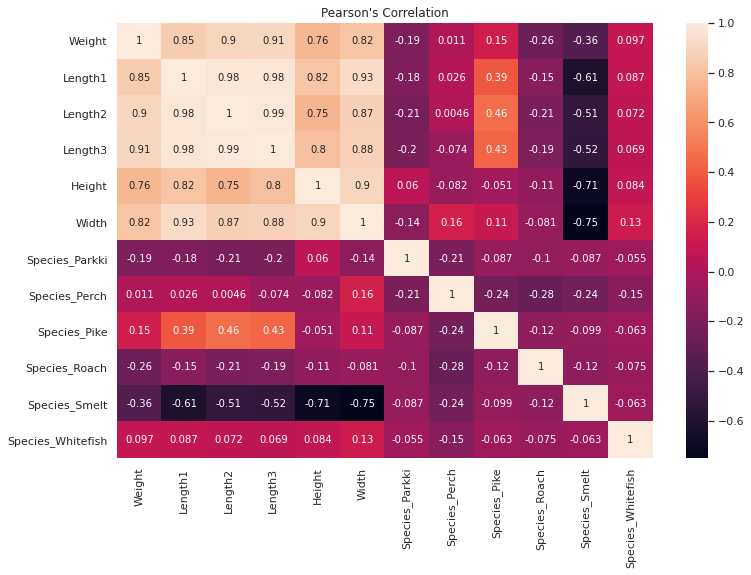

In [251]:
plt.figure(figsize=(12,8))
plt.title("Pearson's Correlation")
sns.heatmap(fishes_trans.corr(), annot=True);
plt.show();

*Observations*
* The response variable, Weight, is most highly correlated with Length1, Length2 and Length3, but all features show high correlation coefficents.

**Spearmen's Correlation**



The key assumptions of using this statistic are,

* It is appropriate when one or both variables are skewed or ordinal1 and is robust when extreme values are present.

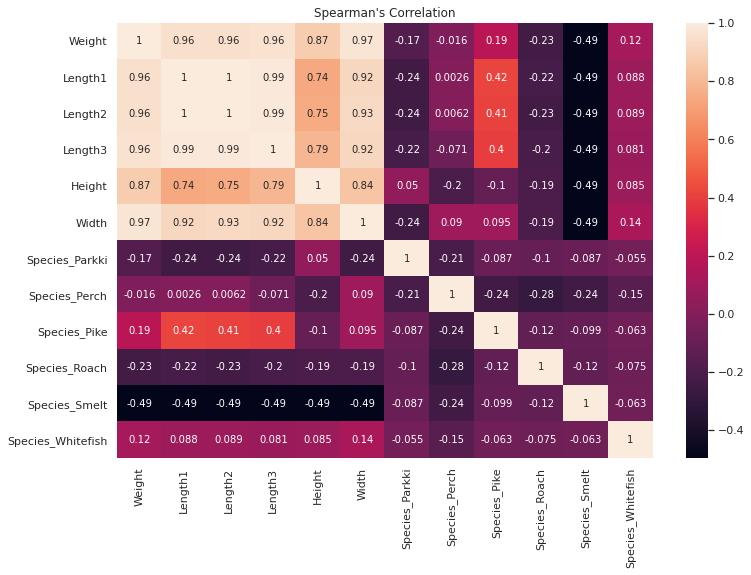

In [252]:
plt.figure(figsize=(12,8))
plt.title("Spearman's Correlation")
sns.heatmap(fishes_trans.corr(method='spearman'), annot=True);
plt.show();

*Observations*
* In contrast to Pearson's correlation we see that highest correlation of `Weight` between `Width` and any of `Length[1,2,3]`, but all features show high correlation coefficents. 
* Features `Length[1,2,3]` are highly colinear 

Lastly, I examine the relationships amongst the variables using a scatter plot.

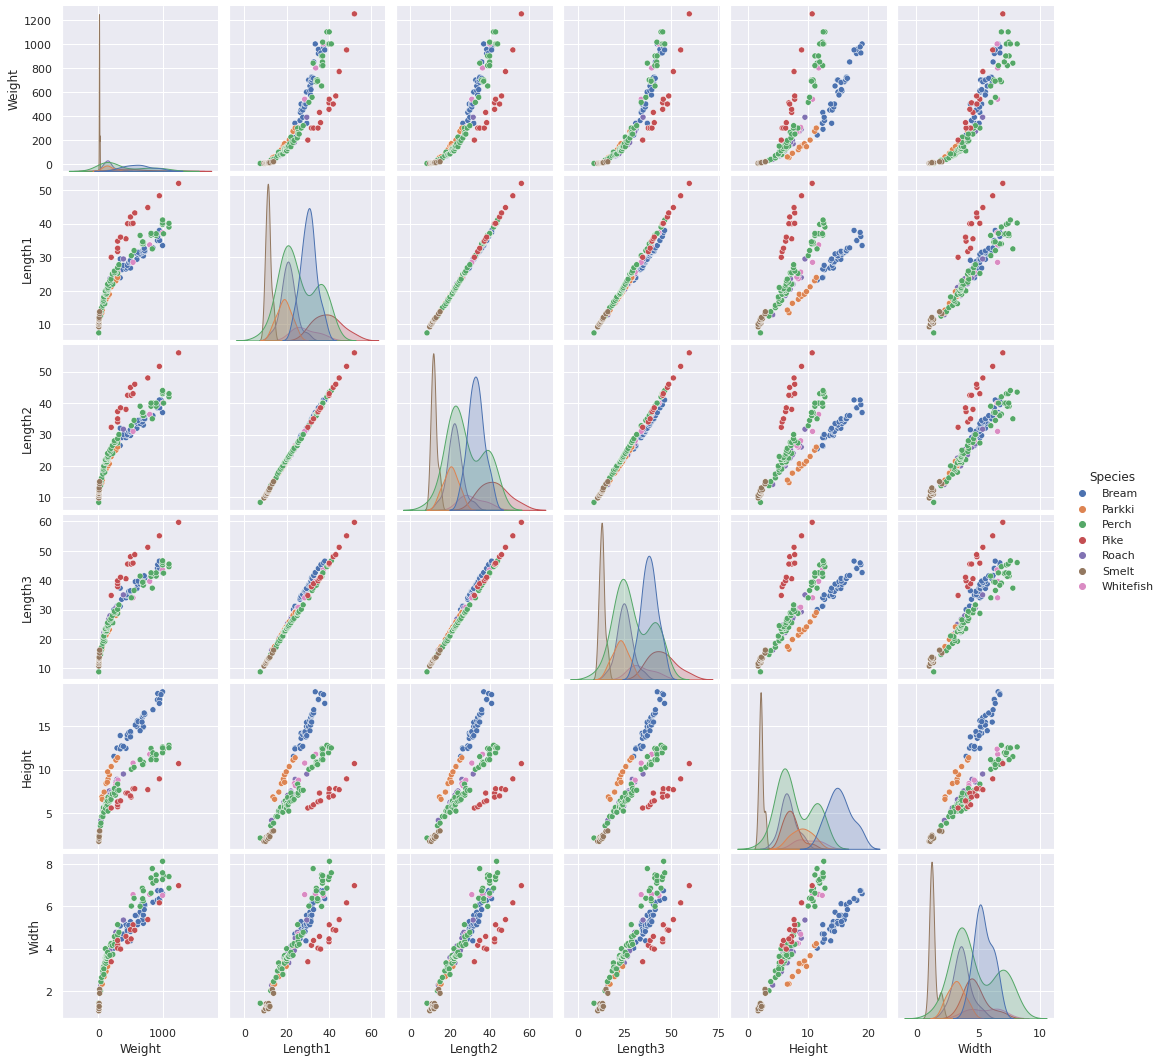

In [102]:
g = sns.pairplot(fishes, kind='scatter', hue='Species');

*Observations*

* There continues to be strong linear relationships between our response variable, `Weight`, and all the features generally.
* There are strong linear relationships between `Weight` and each of the features by `Species`.

# The Model

We saw from Spearmen's correlation and the pair plot above that there are strong linear relationships betweeen `Weight` and serveral of the other variables. 

In [254]:
def plot_linearity_checks(y_pred, y_test, resids):
    fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(15, 8))
    
    sns.regplot(x=y_pred, y=y_test, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Actual vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Actual')

    sns.regplot(x=y_pred, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

**Using Statsmodel**

In [266]:
from statsmodels.formula.api import ols

train, test = train_test_split(fishes, test_size=0.3, random_state=1)

mod = ols(formula='np.log(Weight) ~ np.log(Height) + np.log(Length1) + np.log(Width) + C(Species)', data=train)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Weight)   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2769.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          9.25e-114
Time:                        16:14:08   Log-Likelihood:                 122.81
No. Observations:                 108   AIC:                            -225.6
Df Residuals:                      98   BIC:                            -198.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.8356      0.238     -7.714      0.000      -2.308      -1.363
C(Species)[T.Parkki]        0.0701      0.036      1.963      0.053      -0.001       0.141
C(Species)[T.Perch]         0.1819      0.096      1.891      0.062      -0.009       0.373
C(Species)[T.Pike]          0.2054      0.170      1.211      0.229      -0.131       0.542
C(Species)[T.Roach]         0.1192      0.085      1.405      0.163      -0.049       0.288
C(Species)[T.Smelt]         0.0492      0.155      0.318      0.751      -0.258       0.356
C(Species)[T.Whitefish]     0.2195      0.094      2.324      0.022       0.032       0.407
np.log(Height)              0.8714      0.188      4.642      0.000       0.499       1.244
np.log(Length1)             1.3583      0.166      8.188      0.000       1.029       1.688
np.log(Width)               0.7069      0.131      5.383      0.000       0.446       0.968
==============================================================================
Omnibus:                       30.232   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.251
Skew:                          -0.893   Prob(JB):                     1.70e-22
Kurtosis:                       7.369   Cond. No.                         194.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Test Set Performance*

In [267]:
X_test = test.drop(columns=['Weight'])
y_test = test['Weight']
y_pred = res.predict(X_test)

In [268]:
print('Coefficient of determination: %.3f' % r2_score(np.log(y_test), y_pred))

Coefficient of determination: 0.995


In [269]:
print('Mean squared error: %.2f' % mean_squared_error(np.log(y_test), y_pred))

Mean squared error: 0.01


*No Autocorrelation in residuals.*

The value of the Durbin-Watson test above is ~2, which is the ideal case that indicates no autocorrelation.

*Validate Linearity*

To detect nonlinearity one can inspect plots of actual vs. predicted values or residuals vs. predicted values. The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or around a horizontal line in the latter one. In both cases with a roughly constant variance.

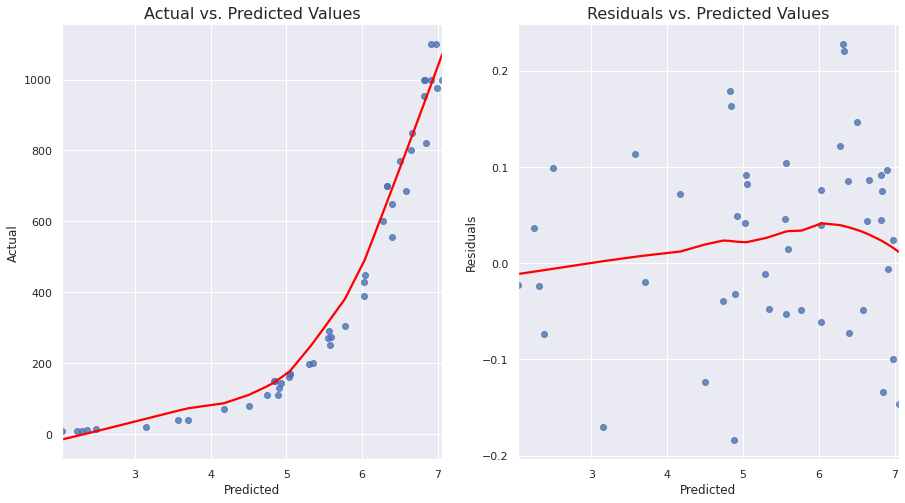

In [270]:
plot_linearity_checks(y_pred, y_test, np.log(y_test) - y_pred);

*Mean of Residuals is Zero*

In [271]:
print('Mean of Residuals: %.3f' % np.mean(np.log(y_test) - y_pred))

Mean of Residuals: 0.022


*Residuals Normally Distributed*

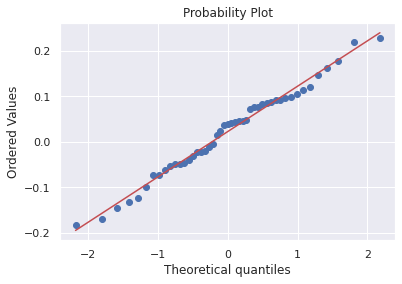

In [272]:
from scipy import stats

stats.probplot(np.log(y_test) - y_pred, plot=plt)
plt.show()

*No Multicollinearity among Predictors*

Multicolinearity is troublesome to detect because it emerges when more than two explanatory variables in a multiple regression model are highly linearly relatedare included within a model. To make matters worst multicolinearity can emerge even when isolated pairs of variables are not colinear. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))


print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
    
# Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

**Using Scikit-Learn (using LinearRegression)**

In [213]:
from sklearn.linear_model import LinearRegression

X = fishes.drop(columns=['Weight', 'Length2', 'Length3'])
X['Width'] = np.log(X['Width'])
X['Height'] = np.log(X['Height'])
X['Length1'] = np.log(X['Length1'])
X = pd.get_dummies(data=X, drop_first=True)

y = np.log(fishes['Weight'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

reg = LinearRegression()
reg.fit(X_train, y_train);

*Test Set Performance*

In [214]:
# Make predictions using the testing set
y_pred = reg.predict(X_test)

In [215]:
print('Coefficient of determination: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination: 0.995


In [216]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

Mean squared error: 0.01


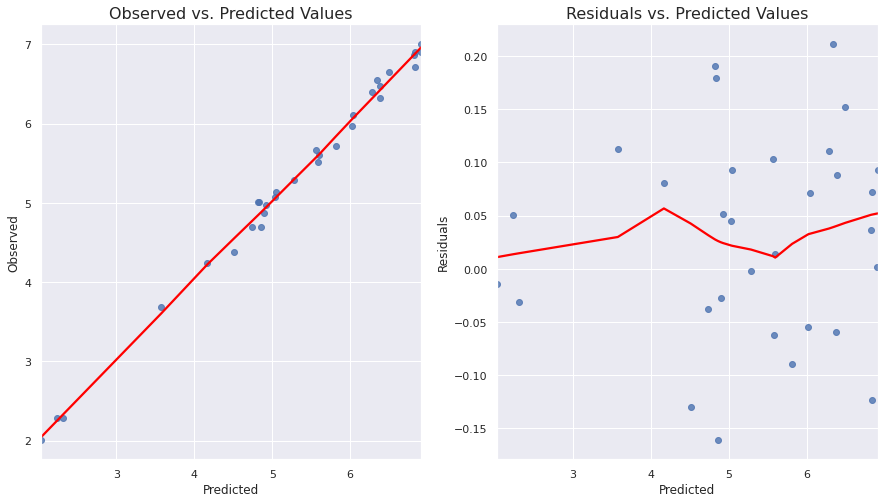

In [217]:
plot_linearity_checks(y_pred, y_test, y_test - y_pred)

*Mean of Residuals is Zero*

In [218]:
print('Mean of Residuals: %.3f' % np.mean(y_test -y_pred))

Mean of Residuals: 0.031


**Using Scikit-Learn (using RANSACRegressor)**

In [219]:
from sklearn.linear_model import RANSACRegressor

X = fishes.drop(columns=['Weight', 'Length2', 'Length3'])
X['Width'] = np.log(X['Width'])
X['Height'] = np.log(X['Height'])
X['Length1'] = np.log(X['Length1'])
X = pd.get_dummies(data=X, drop_first=True)

y = np.log(fishes['Weight'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



ranreg = RANSACRegressor(random_state=42)
ranreg.fit(X_train, y_train);

*Test Set Performance*

In [220]:
# Make predictions using the testing set
y_pred = ranreg.predict(X_test)

In [221]:
print('Coefficient of determination: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination: 0.995


In [222]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

Mean squared error: 0.01


*Validate Linearity*

To detect nonlinearity one can inspect plots of observed vs. predicted values or residuals vs. predicted values. The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or around a horizontal line in the latter one. In both cases with a roughly constant variance.

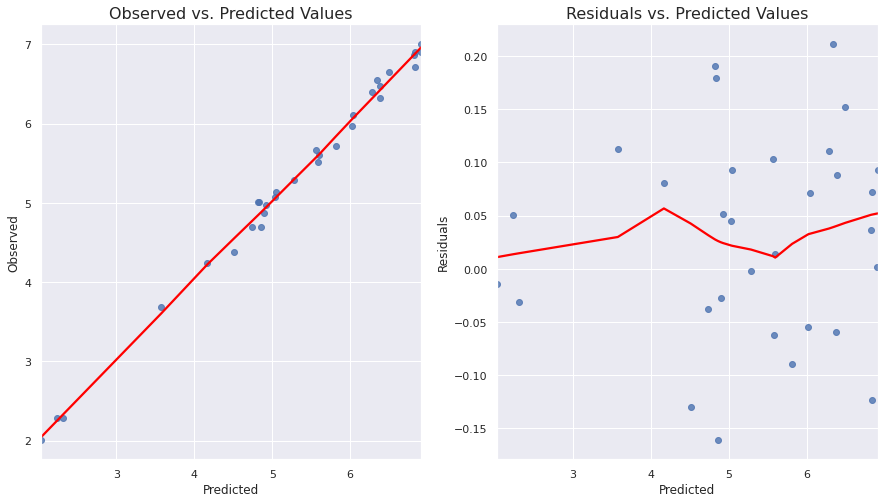

In [223]:
plot_linearity_checks(y_pred, y_test, y_test - y_pred)

*Mean of Residuals is Zero*

In [224]:
print('Mean of Residuals: %.3f' % np.mean(y_test - y_pred))

Mean of Residuals: 0.031


# Conclusion

Several linear regression models were used. All the estimators produced an r2 score of `0.995` on the test set.